# PCA transforming data and evaluating classification schemes.

Here i'm replicating a previous analysis done in MATLAB towards this paper.
The analysis previously performed was good but not terribly well documented, and it was conducted a few years ago so the CAZY database has changed a bit since then.

I'll be trying to follow the steps from before as closely as possible, but the results may be slightly different so the choices might seem a bit weird.

In [1]:
import warnings
import datetime
import os
from os import makedirs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

In [2]:
%matplotlib inline

In [3]:
VERSIONS = ["v4", "v5", "v6", "v7"]
DEFAULT_VERSION = "v5"
TODAY = "20180324"
TODAY = "20190311" #datetime.datetime.utcnow().strftime("%Y%m%d")

First I'll read in my data.
These are counts of different classes of CAZymes for ~122 fungal species, they also have some lifestyle classifications associated with them. 11 of those have "unclassified" trophic classes so i'll need to filter this out.

In [4]:
dfs = dict()
labels = dict()

for version in VERSIONS:
    df = pd.read_csv("02-count_cazymes/{}-cazy_counts.csv".format(version), sep="\t")
    # Remove unclassified species. Leaves 111 rows
    df = df[df["nomenclature1"] != "unclassified"]
    labels[version] = df[["Species", "nomenclature1", "nomenclature2", "nomenclature3"]]
    labels[version].reset_index(drop=True, inplace=True)
    df.set_index("Species", drop=True, inplace=True)
    df.drop(["nomenclature1", "nomenclature2", "nomenclature3"], axis=1, inplace=True)
    df = df.astype(np.float32)
    dfs[version] = df

dfs[DEFAULT_VERSION][:5]

,AA1,AA10,AA11,AA12,AA13,AA2,AA3,AA4,AA5,AA6,...,PL3,PL4,PL5,PL6,PL7,PL8,PL9,SLH,cohesin,dockerin
Species,,,,,,,,,,,,,,,,,,,,,
Agaricus bisporus,2.0,0.0,0.0,1.0,0.0,5.0,33.0,1.0,9.0,4.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Albugo laibachii,2.0,0.0,0.0,0.0,0.0,28.0,2.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alternaria brassicicola,2.0,0.0,4.0,3.0,1.0,7.0,14.0,2.0,3.0,2.0,...,11.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Armillaria mellea,4.0,0.0,1.0,0.0,0.0,12.0,48.0,2.0,4.0,3.0,...,6.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0
Aspergillus fumigatus,1.0,0.0,4.0,0.0,0.0,3.0,11.0,5.0,1.0,2.0,...,3.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
labels[DEFAULT_VERSION][:5]

,Species,nomenclature1,nomenclature2,nomenclature3
0,Agaricus bisporus,saprotroph,saprotroph,saprotroph
1,Albugo laibachii,biotroph,biotroph,biotroph 2
2,Alternaria brassicicola,necrotroph,necrotroph,necrotroph - narrow host range
3,Armillaria mellea,necrotroph,necrotroph,necrotroph - broad host range
4,Aspergillus fumigatus,saprotroph,saprotroph,saprotroph


## Evaluating the classification systems.

First off we want to find out how well our proposed trophic classification system explains the data compared to the traditional system.

As in the previous study, I'll be transforming the counts using PCA and then evaluating the classes with logistic regression.

In [6]:
# Simple utility function for plotting PCA results.

def plot_pca(x, y, labels=labels[DEFAULT_VERSION], ax=None, nom="nomenclature1"):
    if ax is None:
        fig, ax = plt.subplots()

    colours = plt.get_cmap("tab10")
    for i, (nom, subtab) in enumerate(labels.groupby(nom)):        
        x_i = x[subtab.index.values]
        y_i = y[subtab.index.values]
        ax.scatter(x=x_i, y=y_i, c=[colours.colors[i]], alpha=0.7, label=nom)
    
    leg = ax.legend(bbox_to_anchor=(1.0, 1.0), loc=2)
    #ax.add_artist(leg)
    ax.autoscale()
    return fig, ax, leg

So we'll just be using a plain SVD PCA with scaling to reduce the dimensions down to 16 components.

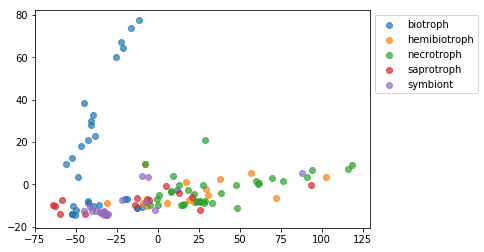

In [7]:
pca = PCA(n_components=16, svd_solver="full")

df_pca = pca.fit_transform(dfs[DEFAULT_VERSION].values)

# Plot the first 2 PCs
fig, ax, leg = plot_pca(df_pca[:,0], df_pca[:,1], nom="nomenclature1")

This doesn't look too bad.
The first PC seems to separate biotrophs symbionts and saprotrophs from the necrotrophs and hemibiotrophs, whereas the second PC separates some of the biotrophs from the others.

What do the other classification systems look like?

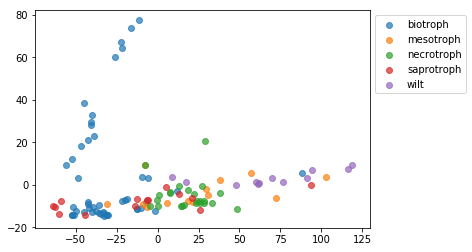

In [8]:
# Plot the first 2 PCs
fig, ax, leg = plot_pca(df_pca[:,0], df_pca[:,1], nom="nomenclature2")

The main change here is that the necrotrophs have been split to include a new group of "wilts".
There appears to be one symbiont that has been reclassified as a biotroph but groups with the wilts.

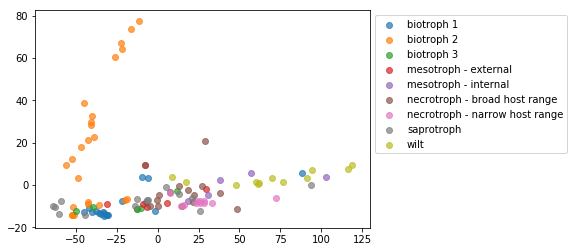

In [9]:
# Plot the first 2 PCs
fig, ax, leg = plot_pca(df_pca[:,0], df_pca[:,1], nom="nomenclature3")

And the new classification system subdivides each of the main groups further.
Generally, these sub groups tend to occur together in the first two PCs.

Let's look at what the logistic classifier thinks of these labels.

In [10]:
def evaluate_model(steps, values=dfs[DEFAULT_VERSION].values, labels=labels[DEFAULT_VERSION]["nomenclature1"]):
    tsne = TSNE(random_state=123, learning_rate=100, n_iter_without_progress=100, n_iter=10000)
    skfold = StratifiedKFold(n_splits = 3, shuffle=True)
    loo = LeaveOneOut()
    pca_pipeline = Pipeline(steps + [("tsne", tsne)])
    pipeline = Pipeline(steps + [("classification", LogisticRegression(solver="liblinear", multi_class="auto"))])

    unique_labels = labels.unique()
    results = dict()
    pipeline.fit(values, labels)
    
    df_tsne = pca_pipeline.fit_transform(values)
    
    fig, ax, leg = plot_pca(df_tsne[:,0], df_tsne[:,1], nom=labels.name)
    _ = fig.suptitle("TSNE of PCA transform")
    plt.show()
    #preds = pipeline.predict(values)
    #results["all"] = classification_report(labels, preds)
    #results["all_cm"] = confusion_matrix(labels, preds, labels=unique_labels)

    """results["k-fold cross validation"] = list()
    for train_idxs, val_idxs in skfold.split(df, labels):
        pipeline.fit(values[train_idxs], labels[train_idxs])
        x = pipeline.predict(values[val_idxs])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            x = classification_report(labels[val_idxs], x)
        results["k-fold cross validation"].append(x)"""

    x = cross_val_predict(pipeline, df, labels, cv=loo)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        results["leave one out validation"] = classification_report(labels, x)

    cm = confusion_matrix(labels, x, labels=unique_labels)
    results["leave one out validation - confusion matrix"] = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    keys = [
        "leave one out validation",
        "leave one out validation - confusion matrix",
        #"k-fold cross validation"
        ]
    
    for k in keys:
        v = results[k]
        print("#", k)
        if isinstance(v, list):
            for v_i in v:
                print(v_i)
        elif isinstance(v, np.ndarray):
            v = pd.DataFrame(v)
            v.index = unique_labels
            v.columns = unique_labels
            ax = sns.heatmap(v)
            ax.set_ylabel("True class")
            ax.set_xlabel("Predicted class")
            plt.show()
        else:
            print(v)

    return results

OK, so what we'll be doing here is:

1. Plotting a TSNE of the PCA transformed counts.
2. Getting the classification metrics from the logistic regression, leaving one data point out each time.
3. Plotting the normalised confusion matrix to see which classes are hard to distinguish.
4. Get the classification metrics for 3-fold cross validation sets (splits the data into 3 different sets of train and test data then runs evaluates each result).

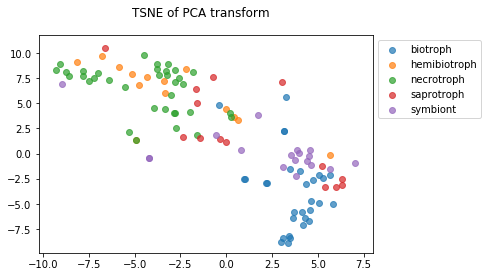

# leave one out validation
              precision    recall  f1-score   support

    biotroph       0.79      0.87      0.83        30
hemibiotroph       0.22      0.14      0.17        14
  necrotroph       0.70      0.80      0.75        35
  saprotroph       0.25      0.21      0.23        14
    symbiont       0.59      0.56      0.57        18

   micro avg       0.62      0.62      0.62       111
   macro avg       0.51      0.52      0.51       111
weighted avg       0.59      0.62      0.60       111

# leave one out validation - confusion matrix


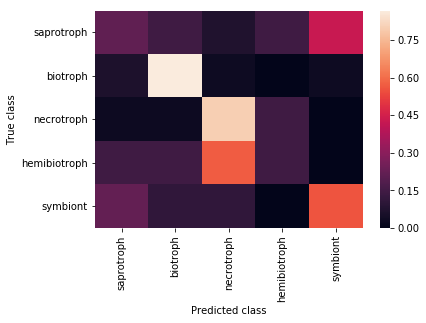

In [11]:
steps = [
    ("decomposition", PCA(n_components=16, svd_solver="full"))
]

_ = evaluate_model(steps, labels=labels[DEFAULT_VERSION]["nomenclature1"])

OK, so looking at the TSNE plot we can see a pretty clear divide in the center between biotrophs and necrotrophs.
Looking at the leave one out cross-validation we see that we are able to recover the correct classification 60% of the time.

The confusion matrix suggests that hemibiotrophs are consistently being incorrectly predicted as necrotrophs.
Also, the saprotrophs are often predicted as biotrophs or symbionts.

These confusions make sense if you look at how they cluster together in the TSNE plot.

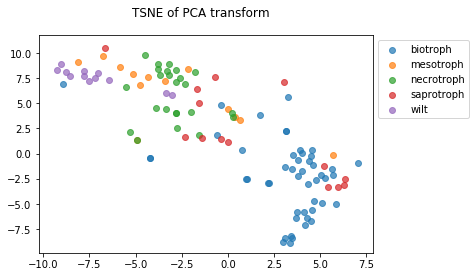

# leave one out validation
              precision    recall  f1-score   support

    biotroph       0.78      0.88      0.82        48
   mesotroph       0.43      0.23      0.30        13
  necrotroph       0.64      0.75      0.69        24
  saprotroph       0.44      0.29      0.35        14
        wilt       0.85      0.92      0.88        12

   micro avg       0.70      0.70      0.70       111
   macro avg       0.63      0.61      0.61       111
weighted avg       0.67      0.70      0.68       111

# leave one out validation - confusion matrix


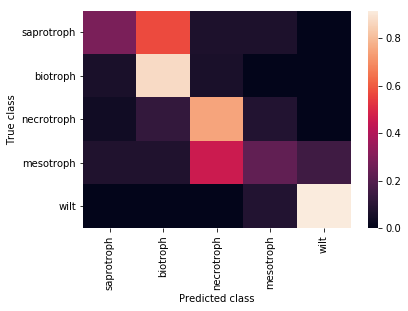

In [12]:
steps = [
    ("decomposition", PCA(n_components=16, svd_solver="full"))
]

_ = evaluate_model(steps, labels=labels[DEFAULT_VERSION]["nomenclature2"])

On to nomenclature2 now and clearly the wilts form a distinct group from the necrotrophs.
We've increase our precision and recall slightly and resolved some of the issues with the necrotrophs and hemibiotrophs.

In the last plot, symbionts was a bit of a problem because it got confused with saprotrophs.
Merging it with the biotroph class still confuses the saprotroph model.

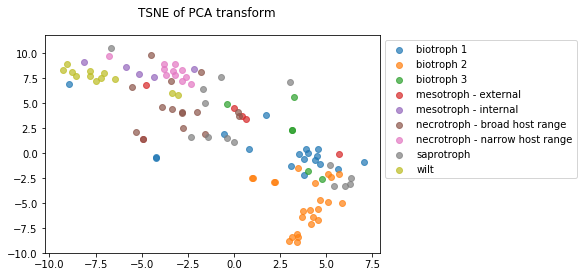

# leave one out validation
                                precision    recall  f1-score   support

                    biotroph 1       0.50      0.61      0.55        18
                    biotroph 2       0.85      0.92      0.88        24
                    biotroph 3       0.00      0.00      0.00         6
          mesotroph - external       0.00      0.00      0.00         6
          mesotroph - internal       0.40      0.40      0.40         5
 necrotroph - broad host range       0.57      0.53      0.55        15
necrotroph - narrow host range       0.71      0.91      0.80        11
                    saprotroph       0.36      0.29      0.32        14
                          wilt       0.80      1.00      0.89        12

                     micro avg       0.62      0.62      0.62       111
                     macro avg       0.47      0.52      0.49       111
                  weighted avg       0.56      0.62      0.59       111

# leave one out validation - confu

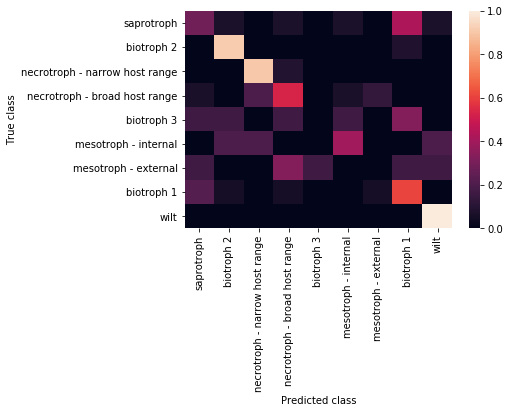

In [13]:
steps = [
    ("decomposition", PCA(n_components=16, svd_solver="full"))
]

_ = evaluate_model(steps, labels=labels[DEFAULT_VERSION]["nomenclature3"])

Finally on to the expanded new classification system.
We're actually taking a cut in precision and recall here compared to both of the previous classification systems.

This confusion seems to be mostly in predicting hemibiotrophs, non-haustorial biotrophs, and saprotrophs which are the three classes with the fewest representative members.
Internal necrotrophs isn't a suprise because we only have one member, but having external hemibiotrophs confused with biotrophs as slightly confusing (though they so sit right in the middle of the biotroph and necrotroph clusters in the TSNE plot).


The TSNE plots suggest that there's scope to split the saprotrophs again into two subgroups.


Although the second nomenclature clearly had better accuracy, I would suggest that this is because we had larger groups.
Looking at the confusion matrix we tend to see incorrect predictions that make sense biologically, so it's likely that the extra information will be useful when looking at multiclass predictions.

## Evaluating different PCA methods

### SVD with scaling but no centering

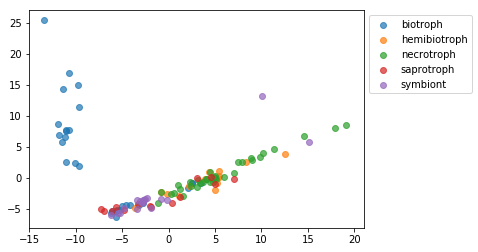

In [14]:
scaler = StandardScaler(with_mean=False, with_std=True)
pca = PCA(n_components=16, svd_solver="full")

df_scaled = scaler.fit_transform(dfs[DEFAULT_VERSION].values)
df_pca = pca.fit_transform(df_scaled)

# Plot the first 2 PCs

fig, ax, leg = plot_pca(df_pca[:,0], df_pca[:,1])

This is similar to the original plot but with tigher grouping in PC2.


### SVD PCA with centering and scaling

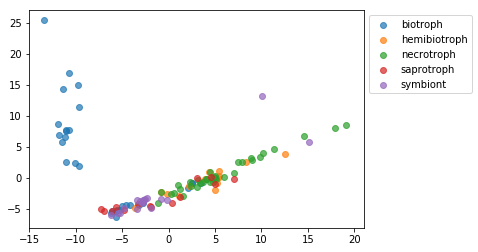

In [15]:
scaler = StandardScaler(with_mean=True, with_std=True)
pca = PCA(n_components=16, svd_solver="full")

df_scaled = scaler.fit_transform(dfs[DEFAULT_VERSION].values)
df_pca = pca.fit_transform(df_scaled)

# Plot the first 2 PCs
fig, ax, leg = plot_pca(df_pca[:,0], df_pca[:,1])

More-or-less the same as PCA without means centering but with scaling.

## Truncated SVD

So because we have lots of "zero" counts scaling by the mean might not make sense.
Commonly people use truncated SVDs when the data is somewhat sparse like ours is.
This is common practise in text processing based on word counts, which is conceptually similar to our dataset.


So here's truncated SVD without scaling.

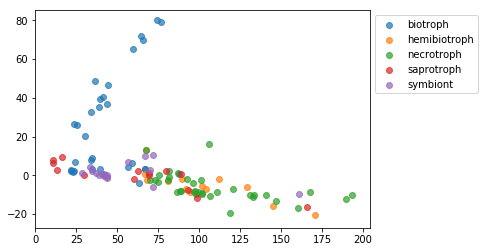

In [16]:
tsvd = TruncatedSVD(n_components=16, algorithm="arpack", random_state=123)

df_tsvd = tsvd.fit_transform(dfs[DEFAULT_VERSION].values)

# Plot the first 2 PCs
fig, ax, leg = plot_pca(df_tsvd[:,0], df_tsvd[:,1])

This looks similar to the first plot with normal SVD.

Now let's try truncated SVD with scaling but not centering.

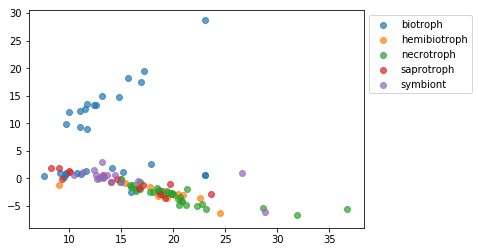

In [17]:
tsvd = TruncatedSVD(n_components=16, algorithm="arpack", random_state=123)
scaler = StandardScaler(with_mean=False, with_std=True)

df_scaled = scaler.fit_transform(dfs[DEFAULT_VERSION].values)
df_tsvd = tsvd.fit_transform(df_scaled)

# Plot the first 2 PCs
fig, ax, leg = plot_pca(df_tsvd[:,0], df_tsvd[:,1])

This plot also looks pretty similar to the original figure.
I like it because 1. it is a slightly more elegant way of handling count-data, and 2 it got rid of that pesky biotroph-symbiont from the top right hand corner (though it did push one of the haustorial biotrophs further along in PC1).

### Using ratios of CAZymes rather than counts.

To me it makes sense to use proportions of total cazymes for each proteome rather than the raw counts.
That way the transformation isn't dependent of the number of CAZymes an organism has.

First we get the row sums...

In [18]:
row_sums = dfs[DEFAULT_VERSION].apply(lambda x: x.sum(), axis=1)
row_sums[:5]

Species
Agaricus bisporus          477.0
Albugo laibachii           287.0
Alternaria brassicicola    589.0
Armillaria mellea          652.0
Aspergillus fumigatus      622.0
dtype: float64

Then we divide each row by the row total.

In [19]:
df_props = dfs[DEFAULT_VERSION].div(row_sums, axis="rows")
df_props[:5]

,AA1,AA10,AA11,AA12,AA13,AA2,AA3,AA4,AA5,AA6,...,PL3,PL4,PL5,PL6,PL7,PL8,PL9,SLH,cohesin,dockerin
Species,,,,,,,,,,,,,,,,,,,,,
Agaricus bisporus,0.004193,0.0,0.000000,0.002096,0.000000,0.010482,0.069182,0.002096,0.018868,0.008386,...,0.002096,0.002096,0.000000,0.0,0.0,0.002096,0.000000,0.0,0.0,0.000000
Albugo laibachii,0.006969,0.0,0.000000,0.000000,0.000000,0.097561,0.006969,0.010453,0.000000,0.006969,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
Alternaria brassicicola,0.003396,0.0,0.006791,0.005093,0.001698,0.011885,0.023769,0.003396,0.005093,0.003396,...,0.018676,0.005093,0.000000,0.0,0.0,0.000000,0.001698,0.0,0.0,0.000000
Armillaria mellea,0.006135,0.0,0.001534,0.000000,0.000000,0.018405,0.073620,0.003067,0.006135,0.004601,...,0.009202,0.003067,0.000000,0.0,0.0,0.004601,0.000000,0.0,0.0,0.001534
Aspergillus fumigatus,0.001608,0.0,0.006431,0.000000,0.000000,0.004823,0.017685,0.008039,0.001608,0.003215,...,0.004823,0.004823,0.001608,0.0,0.0,0.000000,0.001608,0.0,0.0,0.000000


Great!
Now we can try the two better performing PCA methods on these scaled data.

First I'll try normal SVD PCA using scaling.

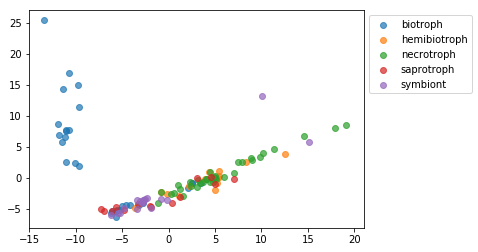

In [20]:
scaler = StandardScaler(with_mean=False, with_std=True)
pca = PCA(n_components=16, svd_solver="full")

df_scaled = scaler.fit_transform(dfs[DEFAULT_VERSION].values)
df_pca = pca.fit_transform(df_scaled)

# Plot the first 2 PCs
fig, ax, leg = plot_pca(df_pca[:,0], df_pca[:,1])

In this case the first 2 PCs really separate the haustorial biotrophs from the rest.
We still see some structure in the bottom cluster though, with the necrotrophs tending to group away from biotrophs.

How about the truncated svd?

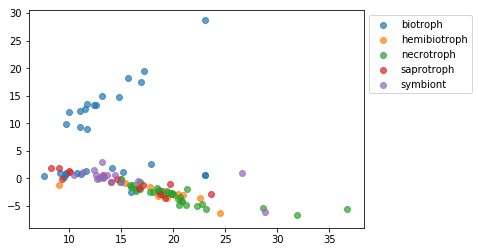

In [21]:
tsvd = TruncatedSVD(n_components=16, algorithm="arpack", random_state=123)
scaler = StandardScaler(with_mean=False, with_std=True)

df_scaled = scaler.fit_transform(dfs[DEFAULT_VERSION].values)
df_tsvd = tsvd.fit_transform(df_scaled)

# Plot the first 2 PCs
fig, ax, leg = plot_pca(df_tsvd[:,0], df_tsvd[:,1])

Again we see a similar structure to the earlier plots that used the counts, but in this case we're starting to approach three clusters in the first 2 PCs (haustorial biotrophs, other biotrophs and necrotrophs/hemobiotrophs/saprotrophs).

I suspect that these plots will give better centroids than the plots based on counts.
But 16 PCs is still a bit too many to evaluate by eye.

I'll do the same TSNE plots and logistic regression tests as I did before but for these new PCA methods to see how thet compare to the plain PCA without scaling.
Remembering that the PCA only method has some trouble predicting the saprotrophs, non-haustorial biotrophs and hemi-biotrophs.


### Truncated SVD with scaling

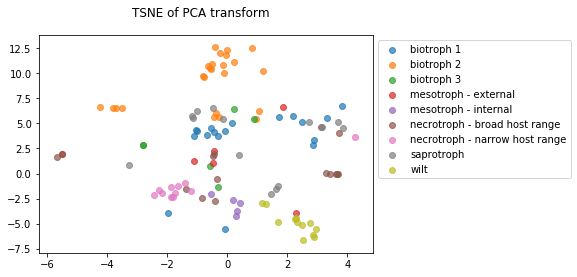

# leave one out validation
                                precision    recall  f1-score   support

                    biotroph 1       0.50      0.56      0.53        18
                    biotroph 2       0.87      0.83      0.85        24
                    biotroph 3       1.00      0.33      0.50         6
          mesotroph - external       0.00      0.00      0.00         6
          mesotroph - internal       0.71      1.00      0.83         5
 necrotroph - broad host range       0.42      0.53      0.47        15
necrotroph - narrow host range       0.91      0.91      0.91        11
                    saprotroph       0.31      0.29      0.30        14
                          wilt       0.86      1.00      0.92        12

                     micro avg       0.64      0.64      0.64       111
                     macro avg       0.62      0.61      0.59       111
                  weighted avg       0.63      0.64      0.62       111

# leave one out validation - confu

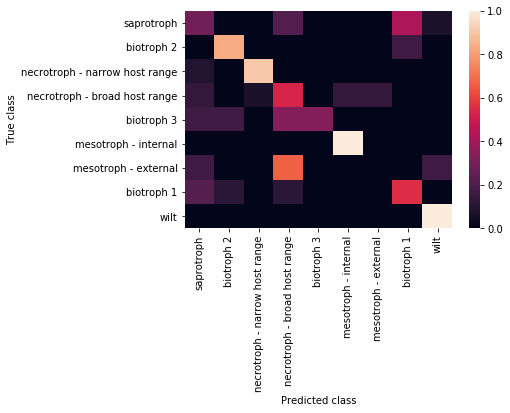

In [22]:


steps = [
    ("scale", StandardScaler(with_mean=False, with_std=True)),
    ("decomposition", TruncatedSVD(n_components=16, algorithm="arpack", random_state=123))
]

# This gives lots of warnings about f32 -> f64 conversion.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    _ = evaluate_model(
        steps,
        dfs[DEFAULT_VERSION].values.astype(np.float64),
        labels=labels[DEFAULT_VERSION]["nomenclature3"]
    )

We've improved our model again!

We still have that problem with resolving saprotrophs and non-haustorial biotrophs from symbiotic biotrophs.
It you look at the TSNE you can see that those groups form a big cluster in the center.

The gains with this sparse model seem to based on our ability to distinguish necrotrophs from biotrophs.
That seems to be due to the necrotroph clusters being smaller rather than reducing variance in the biotrophs.

### Standard PCA with scaling and with CAZY proportions.

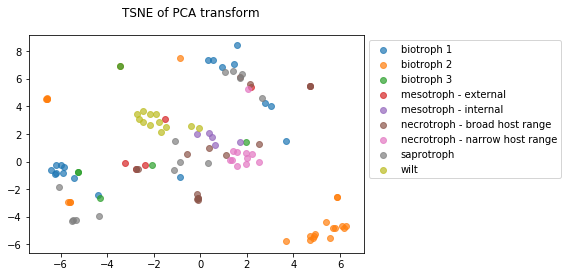

# leave one out validation
                                precision    recall  f1-score   support

                    biotroph 1       0.42      0.56      0.48        18
                    biotroph 2       0.83      0.83      0.83        24
                    biotroph 3       0.00      0.00      0.00         6
          mesotroph - external       0.00      0.00      0.00         6
          mesotroph - internal       0.71      1.00      0.83         5
 necrotroph - broad host range       0.50      0.53      0.52        15
necrotroph - narrow host range       0.77      0.91      0.83        11
                    saprotroph       0.00      0.00      0.00        14
                          wilt       0.86      1.00      0.92        12

                     micro avg       0.59      0.59      0.59       111
                     macro avg       0.45      0.54      0.49       111
                  weighted avg       0.52      0.59      0.55       111

# leave one out validation - confu

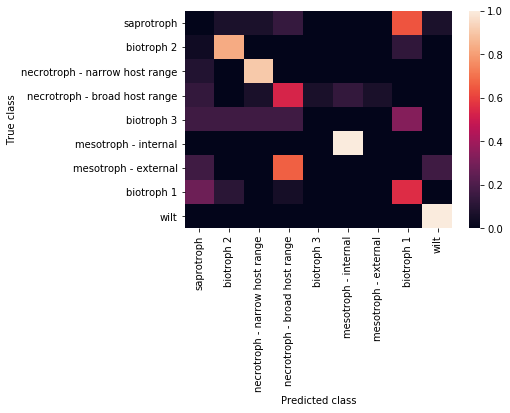

In [23]:
steps = [
    ("scale", StandardScaler(with_mean=False, with_std=True)),
    ("decomposition", PCA(n_components=16, svd_solver="full"))
]

# This gives lots of warnings about f32 -> f64 conversion.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    _ = evaluate_model(
        steps,
        df_props.values,
        labels=labels[DEFAULT_VERSION]["nomenclature3"]
    )

Using the proportions rather than counts doesn't seem to effect the standard PCA much.


### Truncated SVD with scaling and with CAZY proportions.

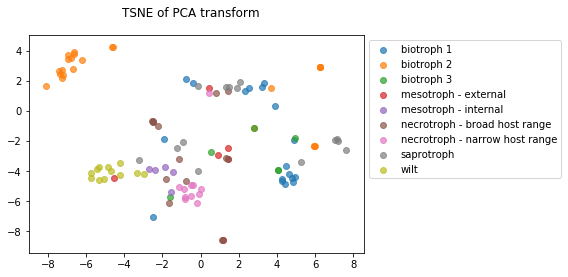

# leave one out validation
                                precision    recall  f1-score   support

                    biotroph 1       0.50      0.56      0.53        18
                    biotroph 2       0.87      0.83      0.85        24
                    biotroph 3       1.00      0.33      0.50         6
          mesotroph - external       0.00      0.00      0.00         6
          mesotroph - internal       0.71      1.00      0.83         5
 necrotroph - broad host range       0.42      0.53      0.47        15
necrotroph - narrow host range       0.91      0.91      0.91        11
                    saprotroph       0.31      0.29      0.30        14
                          wilt       0.86      1.00      0.92        12

                     micro avg       0.64      0.64      0.64       111
                     macro avg       0.62      0.61      0.59       111
                  weighted avg       0.63      0.64      0.62       111

# leave one out validation - confu

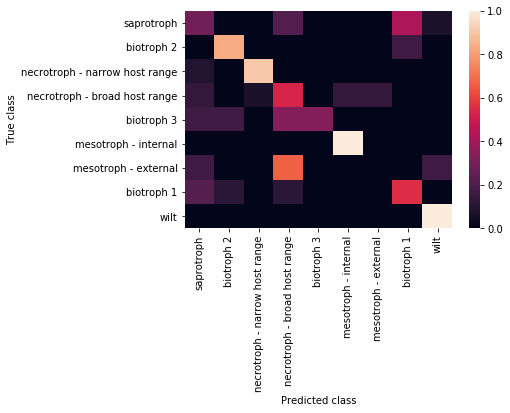

In [24]:
steps = [
    ("scale", StandardScaler(with_mean=False, with_std=True)),
    ("decomposition", TruncatedSVD(n_components=16, algorithm="arpack", random_state=123))
]

# This gives lots of warnings about f32 -> f64 conversion.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    _ = evaluate_model(
        steps,
        values=df_props.values,
        labels=labels[DEFAULT_VERSION]["nomenclature3"]
    )

Again, using proportions seems to give similar results from the classifier.

The interesting thing that I'm seeing in those TSNE plots is a more defined sub-structure within groups.
I suspect that a more complex model might actually perform better than LR.

Generally speaking, there's doesn't seem to be much of a difference between truncated SVD and standard PCA in terms of the relationships between points in multidimensional space.

I chose the TSNE hyperparameters based on what spread out the standard un-normalised PCA the best, but generally it seems like the normalised plots have more circular groups rather than elliptical ones.

To keep in line with the previous analyses i'll continue with the unscaled, regular PCA.

And I'll save the PCs for later.

In [25]:
if not os.path.exists("03-replicating_pca"):
    makedirs("03-replicating_pca")

df_pcas = dict()
pipelines = dict()

for version in VERSIONS:
    pipeline = PCA(n_components=16, svd_solver="full")
    pipeline.fit(dfs[version].values)

    df_pca = pipeline.transform(dfs[version].values)

    df_pca = pd.DataFrame(df_pca)
    df_pca.columns = ["pc{:0>2}".format(i + 1) for i in df_pca.columns]

    df_pca = pd.concat([labels[version], df_pca], axis=1)
    df_pcas[version] = df_pca
    pipelines[version] = pipeline
    
    df_pca.to_csv("03-replicating_pca/{}-principle_components.csv".format(version), sep="\t", index=False)
    np.savez(
        "../catas/data/{}-{}-principle_components.npz".format(version, TODAY),
        rows=df_pca["Species"],
        nomenclature1=df_pca["nomenclature1"],
        nomenclature2=df_pca["nomenclature2"],
        nomenclature3=df_pca["nomenclature3"],
        columns=df_pca.iloc[:, 4:].values
    )

df_pcas[DEFAULT_VERSION][:5]

,Species,nomenclature1,nomenclature2,nomenclature3,pc01,pc02,pc03,pc04,pc05,pc06,pc07,pc08,pc09,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,Agaricus bisporus,saprotroph,saprotroph,saprotroph,-5.596715,-7.175748,20.561199,-18.262674,-5.688208,-0.749536,2.126003,2.103183,5.382176,0.997175,-3.001956,-2.889436,-0.640580,1.840926,-4.674770,2.977663
1,Albugo laibachii,biotroph,biotroph,biotroph 2,-48.502155,3.433361,-1.463343,-3.008712,-10.110828,8.478079,11.548410,3.194017,-4.257336,-15.663615,12.647010,6.322598,1.510813,1.862938,15.264624,2.944969
2,Alternaria brassicicola,necrotroph,necrotroph,necrotroph - narrow host range,7.804736,-3.859394,2.972143,18.226820,1.650082,-3.620947,-0.199021,-2.674036,-0.495409,-0.077786,-5.934555,-0.121204,2.709126,2.499152,1.708681,-3.570464
3,Armillaria mellea,necrotroph,necrotroph,necrotroph - broad host range,21.985218,-4.530297,22.455420,-16.849760,-16.705063,-5.928867,-6.786644,4.643309,7.768957,5.854125,0.323093,-7.940342,-2.196850,5.947209,1.817424,0.575801
4,Aspergillus fumigatus,saprotroph,saprotroph,saprotroph,4.934787,-0.790617,-4.519309,3.308799,11.333103,2.445708,-4.878553,-0.852445,0.517279,7.712803,7.079127,0.724315,-2.419157,-0.792004,3.606709,5.958527


And finally i want to save the model so that we can use the data in the actual program.
Scikit-learn offers a "pickle"-like option for saving the model and it's parameters.
However, this object is not stable across releases so it'll give lots of warnings and could be buggy.

Instead we extract the parts that we need and save them in the more stable numpy format.

In [26]:
for version in VERSIONS:
    mean = pipelines[version].mean_
    components = pipelines[version].components_
    np.savez("../catas/data/{}-{}-model.npz".format(version, TODAY), mean=mean, components=components)

Now we can load exactly the same model using the following command.

In [27]:
model = np.load("../catas/data/{}-{}-model.npz".format(DEFAULT_VERSION, TODAY))
model["mean"]
model["components"]

array([[ 0.04109139, -0.00142345,  0.03516213, ..., -0.00340309,
         0.        , -0.00124115],
       [-0.03063988,  0.00873286, -0.04675135, ..., -0.00375134,
        -0.        ,  0.00333288],
       [-0.02369273, -0.00281275, -0.03853044, ..., -0.02102641,
         0.        , -0.00029691],
       ...,
       [-0.0028675 , -0.00773379,  0.05928832, ..., -0.14901452,
        -0.        , -0.00540208],
       [ 0.0187226 , -0.00342095, -0.01952155, ...,  0.02910978,
        -0.        ,  0.01080113],
       [-0.00583155, -0.01545633, -0.00535324, ..., -0.19152047,
        -0.        ,  0.01112592]], dtype=float32)

And if we run the transform function from catas with our data, we should get the same results.

In [28]:
from catas.predict import transform
from catas.matrix import Matrix

df = dfs[DEFAULT_VERSION]
matrix = Matrix(df.index.tolist(), df.columns.tolist(), df.values)
x = transform(matrix, model)
x

In [29]:
x.arr[1:5, 1:5]

array([[  3.43336034,  -1.46334113,  -3.00871449, -10.11082492],
       [ -3.85939754,   2.97214408,  18.22682637,   1.65008195],
       [ -4.53029797,  22.4554062 , -16.84976419, -16.70506689],
       [ -0.79061696,  -4.51931158,   3.30879682,  11.3331004 ]])

See!?

## PCA figures

In [30]:
mpl.rcParams['lines.linewidth'] = 3
#mpl.rcParams['lines.color'] = 'r'

mpl.rcParams["patch.antialiased"] = True


mpl.rcParams["font.size"] = 13.0
mpl.rcParams["axes.grid"] = False
mpl.rcParams["axes.linewidth"] = 1.5
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["axes.edgecolor"] = "black"
mpl.rcParams['axes.labelsize'] = "Large"
mpl.rcParams['axes.labelweight'] = "bold"

mpl.rcParams["grid.color"] = "E5E5E5"
mpl.rcParams["grid.linestyle"] = "-"
mpl.rcParams["grid.linewidth"] = 1.5

mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.spines.right"] = True

mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5


mpl.rcParams['legend.facecolor'] = "none"
mpl.rcParams['legend.edgecolor'] = "none"
mpl.rcParams['legend.fontsize'] = 12

mpl.rcParams["figure.titlesize"] = 8.

#mpl.rcParams['figure.autolayout'] = False

v4
v5
v6
v7


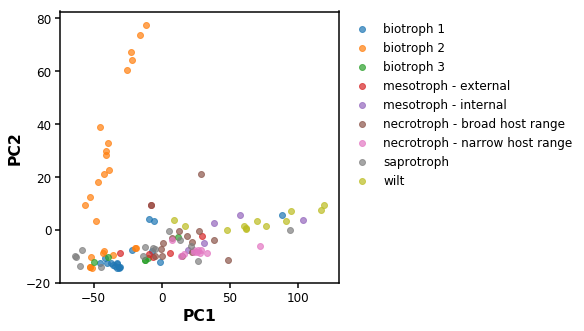

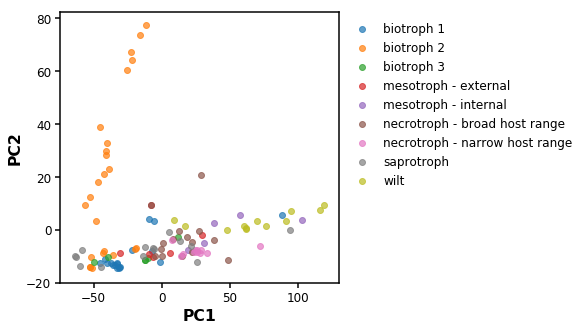

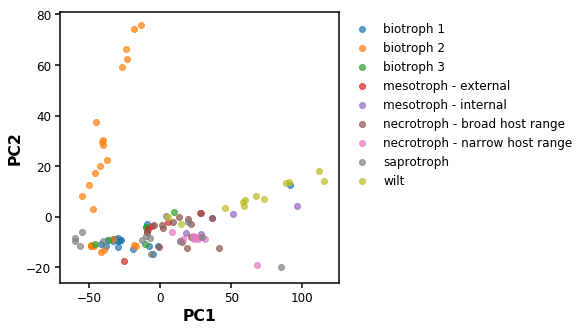

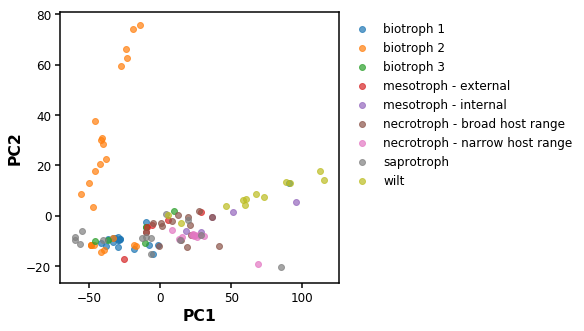

In [31]:
for version in VERSIONS:
    model = np.load("../catas/data/{}-{}-model.npz".format(version, TODAY))
    df = dfs[version]
    matrix = Matrix(df.index.tolist(), df.columns.tolist(), df.values)
    df_pca = transform(matrix, model)

    # Plot the first 2 PCs
    fig, ax, leg = plot_pca(df_pca.arr[:,0], df_pca.arr[:,1], nom="nomenclature3")
    fig.set_size_inches(h=5, w=5)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    print(version)
    fig.savefig("03-replicating_pca/{}-PC1_PC2.svg".format(version), pad_inches=0., bbox_extra_artists=[leg], bbox_inches='tight')

v4
v5
v6
v7


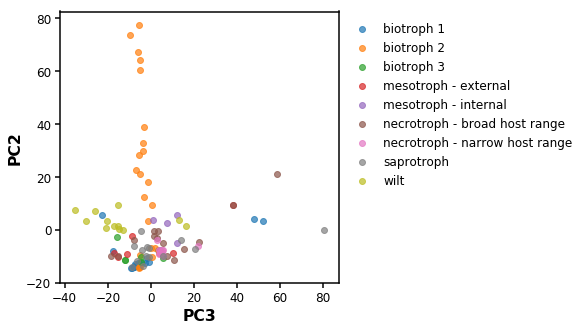

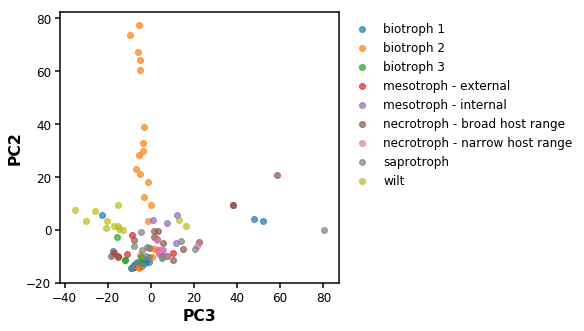

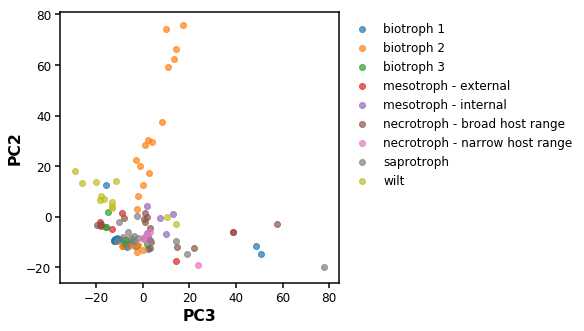

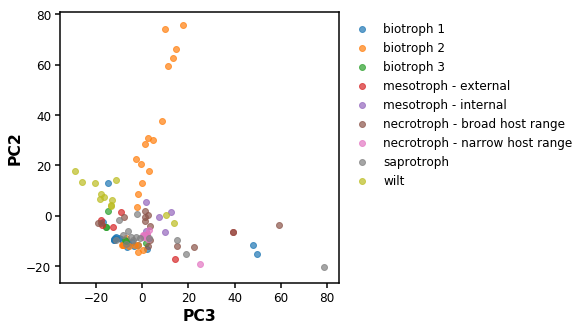

In [32]:
for version in VERSIONS:
    model = np.load("../catas/data/{}-{}-model.npz".format(version, TODAY))
    df = dfs[version]
    matrix = Matrix(df.index.tolist(), df.columns.tolist(), df.values)
    df_pca = transform(matrix, model)

    # Plot the first 2 PCs
    fig, ax, leg = plot_pca(df_pca.arr[:,2], df_pca.arr[:,1], nom="nomenclature3")
    fig.set_size_inches(h=5, w=5)
    ax.set_xlabel("PC3")
    ax.set_ylabel("PC2")
    print(version)
    fig.savefig("03-replicating_pca/{}-PC2_PC3.svg".format(version), pad_inches=0., bbox_extra_artists=[leg], bbox_inches='tight')

v4
v5
v6
v7


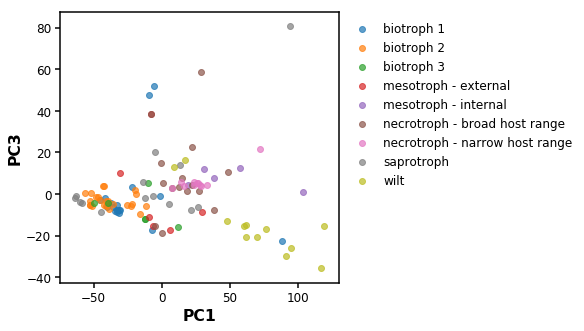

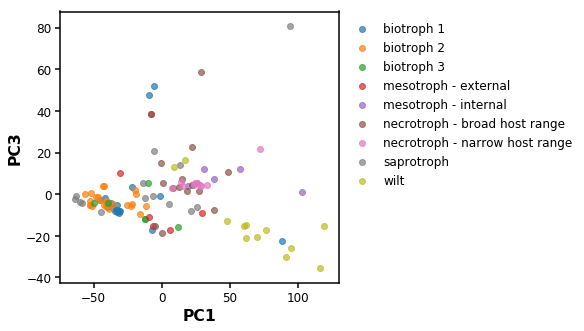

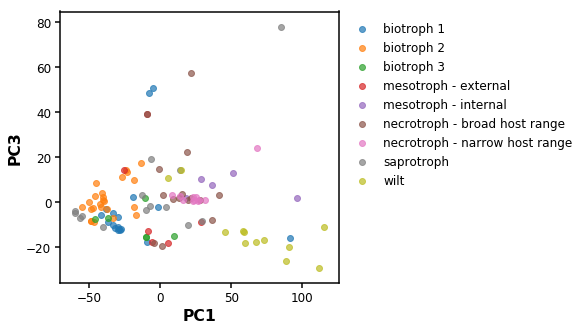

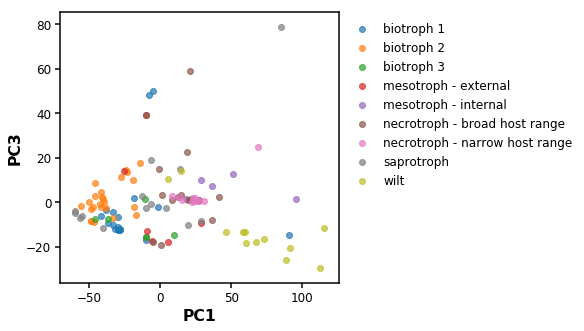

In [33]:
for version in VERSIONS:
    model = np.load("../catas/data/{}-{}-model.npz".format(version, TODAY))
    df = dfs[version]
    matrix = Matrix(df.index.tolist(), df.columns.tolist(), df.values)
    df_pca = transform(matrix, model)

    # Plot the first 2 PCs
    fig, ax, leg = plot_pca(df_pca.arr[:,0], df_pca.arr[:,2], nom="nomenclature3")
    fig.set_size_inches(h=5, w=5)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC3")
    print(version)
    fig.savefig("03-replicating_pca/{}-PC1_PC3.svg".format(version), pad_inches=0., bbox_extra_artists=[leg], bbox_inches='tight')

## PCA tables

In [34]:
pipelines

{'v4': PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
   svd_solver='full', tol=0.0, whiten=False),
 'v5': PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
   svd_solver='full', tol=0.0, whiten=False),
 'v6': PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
   svd_solver='full', tol=0.0, whiten=False),
 'v7': PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
   svd_solver='full', tol=0.0, whiten=False)}

In [35]:
pca_dfs = dict()

for version in VERSIONS:
    model = pipelines[version]
    columns = ["PC{:0>2}".format(i) for i in range(1, 17)]
    rows = dfs[version].columns
    rows.name = "CAZyme"
    pca_df = pd.DataFrame(dict(zip(columns, model.components_)), index=rows)
    pca_df.to_csv("03-replicating_pca/{}-principle_components_loadings.csv".format(version))
    pca_dfs[version] = pca_df

pca_dfs[DEFAULT_VERSION][:5]

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,PC11,PC12,PC13,PC14,PC15,PC16
CAZyme,,,,,,,,,,,,,,,,
AA1,0.041091,-0.030640,-0.023693,0.009938,0.021789,-0.003525,-0.037992,-0.032424,-0.082209,0.044614,-0.002973,0.003107,-0.029543,-0.002868,0.018723,-0.005832
AA10,-0.001423,0.008733,-0.002813,0.000688,-0.002022,0.003009,0.005728,0.013297,0.016493,0.008517,0.001786,0.006199,-0.000890,-0.007734,-0.003421,-0.015456
AA11,0.035162,-0.046751,-0.038530,0.108295,-0.003866,0.039978,-0.017059,0.016612,-0.000791,0.042631,-0.099574,0.017195,0.070059,0.059288,-0.019522,-0.005353
AA12,0.020433,-0.009664,0.004263,0.065357,0.021155,-0.001563,-0.005505,0.015765,-0.029048,-0.019574,-0.030660,0.001341,0.006733,0.037714,0.029526,0.018156
AA13,0.007167,-0.002871,-0.003674,0.016253,0.003704,-0.006250,-0.001895,-0.015063,-0.003781,-0.009384,-0.005766,-0.001101,-0.008314,-0.013004,0.014682,0.004915


## Test data

So that we can unittest these steps, we have some simple sequences to test against the PCA model.

Technically I should be generating this using code independent of what I'm testing, but really I just want to make sure it works.

In [36]:
from importlib import reload

from catas.data import test_dbcan
from catas.data import test_counts
from catas.data import Version
from catas.count import cazy_counts
from catas.predict import transform

In [37]:
for version in VERSIONS:
    cnts = test_counts(Version[version])
    model = np.load("../catas/data/{}-{}-model.npz".format(version, TODAY))
    mat_pca = transform(cnts, model)

    mat_pca.write("../catas/data/{}-{}-test_pcs.npz".format(version, TODAY))